This script takes a tfrecords file produced by "ralpn-make-dataset.ipynb" notebook and trains/tests a neural network for segmentation

In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import IPython.display as display
from PIL import Image
import io
from matplotlib import colors
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dense, Conv2DTranspose, Conv3DTranspose, Cropping2D, Cropping3D, Concatenate, Dropout, Reshape
import scipy.io as sio

In [4]:
tf.keras.backend.clear_session()

In [5]:
# need to know how many classes we are working with!
# in this case 5: background, LK, RK, AA, IVC
numClasses = 5
imageDimension = 384;
numResampledSlices = 32
paddedImageNumLayers = 224
maskDimension = 192

In [6]:
mat_images = sio.loadmat('data_images.mat')
mat_masks = sio.loadmat('data_masks.mat')
data_images = np.ndarray.astype(mat_images['data_images']*(1/255.0),'float32')
data_masks = np.ndarray.astype(mat_masks['data_masks'],'float32')

numExamples = np.size(data_images,0)
print(numExamples)

# format image volume
inputImageVolume = np.zeros([numExamples,imageDimension,imageDimension,paddedImageNumLayers])
inputImageVolume[:,:,:,96:(96+numResampledSlices)] = data_images
inputImageVolume = np.expand_dims(inputImageVolume,4)
inputImageVolume = np.ndarray.astype(inputImageVolume,'float32')
# format mask volume
inputMaskVolume = np.zeros([numExamples,maskDimension,maskDimension,numResampledSlices,numClasses])
inputMaskVolume = data_masks[:,96:(96+maskDimension),96:(96+maskDimension),:,:]

print(np.shape(inputImageVolume))
print(np.shape(inputMaskVolume))

importDataset = tf.data.Dataset.from_tensor_slices((inputImageVolume, inputMaskVolume))
print(importDataset)

9
(9, 384, 384, 224, 1)
(9, 192, 192, 32, 5)
<TensorSliceDataset shapes: ((384, 384, 224, 1), (192, 192, 32, 5)), types: (tf.float32, tf.float32)>


In [7]:
# count number of examples in this dataset
# ideally we'd have already computed this and imported data as a tf.data.Dataset
# but just count the examples for now
numExamples = sum([1 for i in importDataset])
print(numExamples)

9


In [8]:
# function to apply a segmentation mask to an image
def apply_mask_to_image(image_arr,seg_mask):
    mask_colors = np.array([[0, 0, 0], [255,191,0], [0,255,0], [255,84,84], [84,84,255]])/255.0
    
    # convert mask from one-hot to a dense 2D array if necessary
    seg_mask = seg_mask.squeeze()
    #print('seg mask dims:',seg_mask.ndim)
    if(seg_mask.ndim == 3):
        mask_arr_dense = tf.argmax(seg_mask,axis=2).numpy()
    else:
        mask_arr_dense = seg_mask
    
    #seg_mask = tf.argmax(seg_mask,axis=1).numpy()
    #mask_arr_dense = seg_mask.reshape((320,320))
   
    #print('mask_arr_dense shape:',np.shape(mask_arr_dense.shape))

    # embed reduced segmentation mask in the center of a 512x512 array of zeros
    mask_arr_dense = np.squeeze(mask_arr_dense)
    #mask_arr = np.zeros([512,512])
    #mask_arr[96:416,96:416] = mask_arr_dense  # remember! numpy indexing is startidx:(stopidx+1)... weird...
    mask_arr = mask_arr_dense
    
    # otherwise just use this...
    # mask_arr = mask_arr_dense;
    
    # image_arr comes in as a 512x512 matrix of float32 (?) values on [0,1]
    # we need to expand it to be a 512x512x3 RGB image of the same type and range
    #image_arr = tf.squeeze(image_arr)  # will come in as shape (512,512,1); remove last dimension; opposite is tf.expand_dims()
    image_arr = image_arr.squeeze()   # in case it comes in as (512,512,1)
    #print('INPUT IMAGE NEW SHAPE: ',np.shape(image_arr))

    image_arr = np.expand_dims(image_arr,2)
    image_arr = np.tile(image_arr,(1,1,3))
    
    # convert from RGB to HSV  (note: this could be done in tensorflow with tf.image.rgb_to_hsv)
    image_hsv_arr = colors.rgb_to_hsv(image_arr)
    
    # apply mask for each label class
    for labelIdx in range(5):
        
        # get label_mask
        label_mask = (mask_arr == labelIdx)
        
        # get color
        this_color_hsv = colors.rgb_to_hsv(mask_colors[labelIdx,:])
        
        # update hue
        image_hsv_arr[:,:,0] = image_hsv_arr[:,:,0] + np.multiply(this_color_hsv[0], label_mask)
        
        # update saturation
        image_hsv_arr[:,:,1] = image_hsv_arr[:,:,1] + np.multiply(this_color_hsv[1], label_mask)

    # convert back to RGB
    new_image =  colors.hsv_to_rgb(image_hsv_arr)
        
    # return masked image
    return new_image   

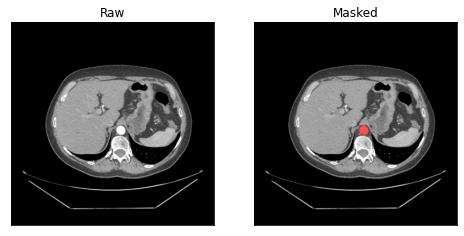

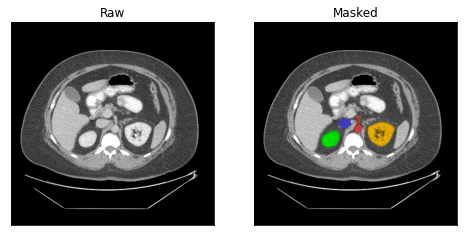

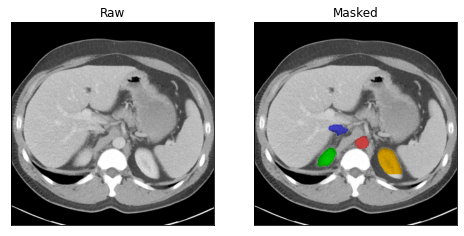

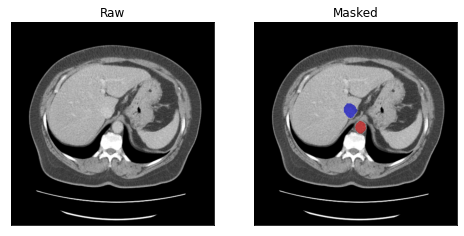

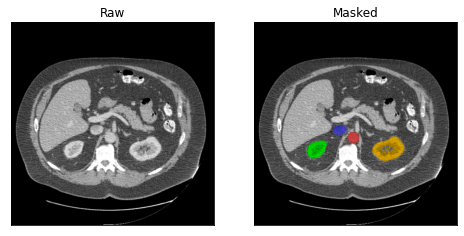

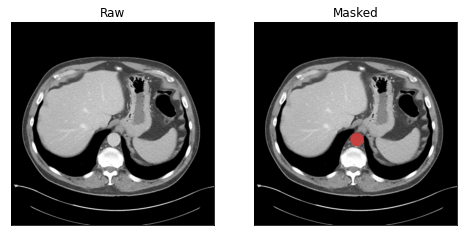

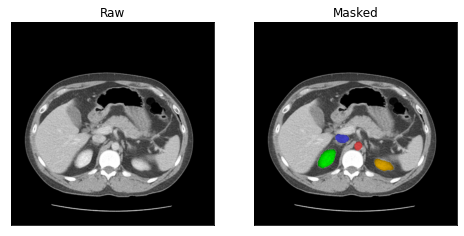

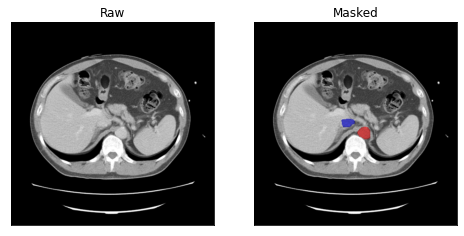

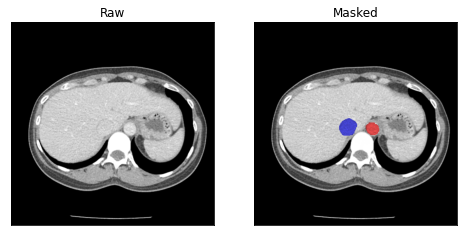

In [7]:
# look at an example image
for example in importDataset:
    
    # extract image VOLUME and mask VOLUME from the tensor for this training example
    image_vol = example[0].numpy()
    seg_mask_vol_onehot = example[1].numpy()
    #print('Image tensor shape: ', image_vol.shape)
    #print('Segmentation mask tensor shape: ', seg_mask_vol_onehot.shape)

    # extract one image PLANE and segmentation mask PLANE from this array
    disp_idx = 24
    this_image = image_vol[:,:,disp_idx+96,0]
    #this_image = image_vol[96:608,96:608,disp_idx+96,0]    
    
    this_seg_mask = np.zeros([imageDimension,imageDimension,5])
    this_seg_mask[96:(96+maskDimension),96:(96+maskDimension),:] = seg_mask_vol_onehot[:,:,disp_idx,:]  # remember! numpy indexing is startidx:(stopidx+1)... weird...
    
    #print('Image shape: ', this_image.shape)
    #print('Segmentation mask shape: ', this_seg_mask.shape)
     
    # produce masked image
    image_masked_arr = apply_mask_to_image(this_image,this_seg_mask)
    
    # display with matplotlib
    fig = plt.figure(figsize=(8,8))
    sp_axes = fig.subplots(1,2)
    sp_axes[0].imshow(this_image,cmap='gray',vmin=0,vmax=1)
    sp_axes[0].get_xaxis().set_visible(False)
    sp_axes[0].get_yaxis().set_visible(False)
    sp_axes[0].set_title('Raw')
    
    sp_axes[1].imshow(image_masked_arr)
    sp_axes[1].get_xaxis().set_visible(False)
    sp_axes[1].get_yaxis().set_visible(False)
    sp_axes[1].set_title('Masked')    

In [9]:
# split into training and test sets
# https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
test_size = int(max(1,int(0.05 * numExamples)))
val_size = int(0 * numExamples)
train_size = numExamples - (test_size + val_size)
ds_full = importDataset.shuffle(numExamples)
ds_train = ds_full.take(train_size)
ds_test = ds_full.take(test_size)
ds_val = ds_full.take(val_size)

In [10]:
# batch and shuffle TRAINING data
ds_train = ds_train.cache()   # cache dataset for more efficient shuffling and prevent reloading in each epoch
ds_train = ds_train.shuffle(train_size)  # shuffle with buffer set to same size as dataset (ideal)
ds_train = ds_train.batch(1)   # batch(N) -> arrange into batches of size N elements each
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE) # performance enhancement https://www.tensorflow.org/guide/data_performance#prefetching

In [11]:
# batch but DO NOT SHUFFLE TEST and VALIDATION data
# directly from https://www.tensorflow.org/datasets/keras_example
ds_test = ds_test.batch(1)   # batch(N) -> arrange into batches of size N elements each
ds_test = ds_test.cache()      # cache dataset to prevent reloading in each epoch
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)  # performance enhancement https://www.tensorflow.org/guide/data_performance#prefetching

In [12]:
# check sizes
#tf.data.experimental.cardinality(importDataset)   # will return: tf.data.experimental.INFINITE_CARDINALITY
#print('Dataset size:',sum(1 for expmple in ds_full))
#train_size_true = sum(1 for expmple in ds_train)
#test_size_true = sum(1 for expmple in ds_test)
#val_size_true = sum(1 for expmple in ds_val)
#train_size_true + test_size_true + val_size_true

In [15]:
# Functional API from: https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification
# Mostly following U-Net structure from Ronneberger2015

#out_1a = Input(shape=(572, 572,1),name='1A')
out_1a = Input(shape=(imageDimension, imageDimension, paddedImageNumLayers, 1),name='1A')
out_1b = Conv3D(2, (3, 3, 3), activation='relu',name='1B')(out_1a)
out_1c = Conv3D(2, (3, 3, 3), activation='relu',name='1C')(out_1b)

out_2a = MaxPooling3D(pool_size=(2, 2, 2),name='2A')(out_1c)
out_2b = Conv3D(4, (3, 3, 3), activation='relu',name='2B')(out_2a)
out_2c = Conv3D(4, (3, 3, 3), activation='relu',name='2C')(out_2b)
out_2d = Conv3D(4, (3, 3, 3), activation='relu',name='2D')(out_2c)

out_3a = MaxPooling3D(pool_size=(2, 2, 2),name='3A')(out_2d)
out_3b = Conv3D(8, (3, 3, 3), activation='relu',name='3B')(out_3a)
out_3c = Conv3D(8, (3, 3, 3), activation='relu',name='3C')(out_3b)

out_4a = MaxPooling3D(pool_size=(2, 2, 2),name='4A')(out_3c)
out_4b = Conv3D(16, (3, 3, 3), activation='relu',name='4B')(out_4a)
out_4c = Conv3D(16, (3, 3, 3), activation='relu',name='4C')(out_4b)
#out_4c_do = Conv3D(512, (3, 3, 3), activation='relu',name='4C')(out_4b)
#out_4c = Dropout(rate=0.5,name='Drop4')(out_4c_do,training=True)       # not entirely sure of dropout placement, following Ronneberger's code

out_5a = MaxPooling3D(pool_size=(2, 2, 2),name='5A')(out_4c)
out_5b = Conv3D(32, (3, 3, 3), activation='relu',name='5B')(out_5a)
out_5c = Conv3D(32, (3, 3, 3), activation='relu',name='5C')(out_5b)
#out_5c_do = Conv2D(1024, (3, 3), activation='relu',name='5C')(out_5b)
#out_5c = Dropout(rate=0.5,name='Drop5')(out_5c_do,training=True)       # not entirely sure of dropout placement, following Ronneberger's code

out_4d = Cropping3D(cropping=((4, 4), (4, 4), (4,4)),name='4D')(out_4c)
out_4e = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), activation='relu',name='4E')(out_5c)  # up-convolution: http://bamos.github.io/2016/08/09/deep-completion/
out_4f = Concatenate(name='4F')([out_4d, out_4e])
out_4g = Conv3D(16, (3, 3, 3), activation='relu',name='4G')(out_4f)
out_4h = Conv3D(16, (3, 3, 3), activation='relu',name='4H')(out_4g)

out_3d = Cropping3D(cropping=((16, 16), (16, 16), (16, 16)),name='3D')(out_3c)
out_3e = Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), activation='relu',name='3E')(out_4h)
out_3f = Concatenate(name='3F')([out_3d, out_3e])
out_3g = Conv3D(8, (3, 3, 3), activation='relu',name='3G')(out_3f)
out_3h = Conv3D(8, (3, 3, 3), activation='relu',name='3H')(out_3g)

out_2e = Cropping3D(cropping=((40, 40), (40, 40), (40,40)),name='2E')(out_2d)
out_2f = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), activation='relu',name='2F')(out_3h)
out_2g = Concatenate(name='2G')([out_2e, out_2f])
out_2h = Conv3D(4, (3, 3, 3), activation='relu',name='2H')(out_2g)
out_2i = Conv3D(4, (3, 3, 3), activation='relu',name='2I')(out_2h)
out_2j = Conv3D(4, (3, 3, 3), activation='relu',name='2J')(out_2i)

out_1d = Cropping3D(cropping=((92, 92), (92, 92), (92, 92)),name='1D')(out_1c)
out_1e = Conv3DTranspose(2, (2, 2, 2), strides=(2, 2, 2), activation='relu',name='1E')(out_2j)
out_1f = Concatenate(name='1F')([out_1d, out_1e])
out_1g = Conv3D(2, (3, 3, 3), activation='relu',name='1G')(out_1f)
out_1h = Conv3D(2, (3, 3, 3), activation='relu',name='1H')(out_1g)
out_1i = Conv3D(numClasses, (1, 1, 1), activation='softmax',name='1I')(out_1h)
#out_classify = Reshape((102400,1))(out_1i)
#x = Flatten()(out_classify)
#x = Dense(5, activation='softmax')(out_classify)
model = Model(inputs=out_1a, outputs=out_1i)
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,to_file='model_plot.png',dpi=600)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [16]:
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
1A (InputLayer)                 [(None, 384, 384, 22 0                                            
__________________________________________________________________________________________________
1B (Conv3D)                     (None, 382, 382, 222 56          1A[0][0]                         
__________________________________________________________________________________________________
1C (Conv3D)                     (None, 380, 380, 220 110         1B[0][0]                         
__________________________________________________________________________________________________
2A (MaxPooling3D)               (None, 190, 190, 110 0           1C[0][0]                         
____________________________________________________________________________________________

In [17]:
# from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    #weights = tf.constant(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /=tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # calc
        loss = y_true *tf.keras.backend.log(y_pred) * weights
        loss = -tf.keras.backend.sum(loss, -1)
        return loss
    
    return loss


# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = tf.ones(tf.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = tf.keras.backend.sum(p0*g0, (0,1,2), keepdims=True)
    den = num + alpha*tf.keras.backend.sum(p0*g1,(0,1,2), keepdims=True) + beta*tf.keras.backend.sum(p1*g0,(0,1,2), keepdims=True)
    
    T = tf.keras.backend.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = tf.keras.backend.cast(tf.keras.backend.shape(y_true)[-1], 'float32')
    return Ncl-T
    #return tf.keras.backend.cast(-1,'float32')

    
# https://github.com/keras-team/keras/issues/9395    
def dice_coef(y_true, y_pred):
    smooth=1e-7
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=3):
    dice=0
    w = [0.0103,0.5116,0.4781]
    #w = [ 0.9600,    0.0193,    0.0207]
    for index in range(numLabels-1):
        # IS INDEXING CORRECT HERE????
        dice -= dice_coef(y_true[:,:,:,index+1], y_pred[:,:,:,index+1])*w[index+1]
        
        seg_label_true = y_true[:,:,:,index+1]
        seg_label_pred = y_pred[:,:,:,index+1]
        
        print(seg_label_true)
        
    return dice


# https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
# NOT MULTICLASS!
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = tf.keras.backend.flatten(inputs)
    targets = tf.keras.backend.flatten(targets)
    
    intersection = tf.keras.backend.sum(tf.keras.backend.dot(targets, inputs))
    dice = (2*intersection + smooth) / (tf.keras.backend.sum(targets) + tf.keras.backend.sum(inputs) + smooth)
    return 1 - dice

    

In [18]:
# weight losses due to class imbalence
class_weight_dic = {0: 0.01,
                    1: 1.0,
                    2: 1.0,
                    3: 1.0,
                    4: 1.0}
#opt = tf.keras.optimizers.Adam(learning_rate=500.0)
#model.compile(opt,loss=dice_coef_multilabel,metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=3)])

weights = tf.constant([0.0016,0.1545,0.1442,0.3812,0.3185],dtype=tf.float32)
#weights = tf.constant([0.0103,0.5116,0.4781],dtype=tf.float32)

#model.compile(optimizer='sgd',
#              loss='mse',
#              metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=5)])

model.compile(optimizer='adam',
             loss=weighted_categorical_crossentropy(weights),
             metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=5)])

#model.compile(optimizer=tf.keras.optimizers.SGD(),
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              loss_weights=class_weight_dic,
#              metrics=['accuracy'])


#tfa.losses.GIoULoss()
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=5)])


#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

In [ ]:

# train model
model_history = model.fit(ds_train,epochs=20,validation_data=ds_test)#,class_weight=class_weight_dic)

Train for 8 steps, validate for 1 steps
Epoch 1/20
4/8 [==============>...............] - ETA: 5:03 - loss: 0.0184 - accuracy: 0.2030 - mean_io_u: 0.4947

In [ ]:
# look at some predictions
for example in ds_test.take(10):
    #print(example)
    #print('Image tensor shape: ', example[0].shape)
    #print('Segmentation mask tensor shape: ', example[1].shape)

    # extract image array
    image_arr = example[0].numpy()
    image_arr = image_arr[0,:,:,:].squeeze()

    #print('image_arr shape:', np.shape(image_arr))
    
    
    # extract label array, then produce masked image
    
    seg_mask_arr = example[1].numpy()
    seg_mask_arr = seg_mask_arr[0,:,:,:].squeeze()
    #print('seg_mask_arr shape:', np.shape(seg_mask_arr))
    image_masked_arr = apply_mask_to_image(image_arr,seg_mask_arr)
    #print('image_masked_arr shape:', np.shape(image_masked_arr))
   
    # make a prediction
    predict_seg_mask_arr = model.predict(example[0])
    predict_seg_mask_arr = predict_seg_mask_arr[0,:,:,:].squeeze()
    #print('predict_seg_mask_arr shape:', np.shape(predict_seg_mask_arr))
    predict_image_masked_arr = apply_mask_to_image(image_arr,predict_seg_mask_arr)
    #print('predict_image_masked_arr shape:', np.shape(predict_image_masked_arr))
    
    # some other methods of displaying images
    # note: display.Image != Image()... first is actually IPython.display.Image() and second is PIL.Image()
    # display.display(display.Image(data=tf.image.encode_png(image_arr).numpy(),width=200))   # easily resizable, but can't put images next to each other (automatic newline after each)
    # display.display(Image.fromarray(image_arr))   #### EASIEST WAY TO DISPLAY AN IMAGE FROM A NUMPY ARRAY!!!, BUT CAN'T SET DISPLAY SIZE? #########
    # Image.fromarray((image_masked_arr*255).astype(np.uint8),mode='RGB') # works for 512x512x3 RGB image, but can't resize?
    # Image.fromarray((image_arr*255).astype(np.uint8),mode='L') # works for 512x512 gray image, but can't resize?

    # display with matplotlib
    fig = plt.figure(figsize=(8,8))
    sp_axes = fig.subplots(1,3)
    sp_axes[0].imshow(image_arr,cmap='gray',vmin=0,vmax=1)
    sp_axes[0].get_xaxis().set_visible(False)
    sp_axes[0].get_yaxis().set_visible(False)
    sp_axes[0].set_title('Raw')
    
    sp_axes[1].imshow(image_masked_arr)
    sp_axes[1].get_xaxis().set_visible(False)
    sp_axes[1].get_yaxis().set_visible(False)
    sp_axes[1].set_title('Masked (Truth)')
    
    sp_axes[2].imshow(predict_image_masked_arr)
    sp_axes[2].get_xaxis().set_visible(False)
    sp_axes[2].get_yaxis().set_visible(False)
    sp_axes[2].set_title('Masked (Prediction)')
    
    #seg_mask_out = tf.argmax(predict_seg_mask_arr,axis=2).numpy()
    
    #print(seg_mask_out)
    #print('max: ',np.amax(predict_seg_mask_arr,(0,1,2)))
    sio.savemat('test.mat', {'predict_seg_mask_arr':predict_seg_mask_arr})

In [ ]:
# FINAL PREDICTION FOR A FULL DATASET
numExamples = sum([1 for i in finalTestsetParsed])
#print(numExamples)
final_masks = np.zeros([512,512,numExamples])
#np.shape(final_masks[:,:,0])
final_mask_idx = 0

# look at some predictions
for example in finalTestsetParsed: #.take(2):
    #print(example)
    #print('Image tensor shape: ', example[0].shape)
    #print('Segmentation mask tensor shape: ', example[1].shape)

    # extract image array
    image_arr = example[0].numpy()
    #image_arr = image_arr[0,:,:].squeeze()
    #print('image_arr shape:', np.shape(image_arr))
    
    # extract label array, then produce masked image
    seg_mask_arr = example[1].numpy()
    #seg_mask_arr = seg_mask_arr[0,:,:,:].squeeze()
    #print('seg_mask_arr shape:', np.shape(seg_mask_arr))

   
    # make a prediction
    input_tensor = tf.expand_dims(example[0], axis=0)
    predict_seg_mask_arr = model.predict(input_tensor)
    predict_seg_mask_arr = predict_seg_mask_arr[0,:,:,:].squeeze()
    #print('predict_seg_mask_arr shape:', np.shape(predict_seg_mask_arr))
    
    # save this prediction
    final_masks[96:416,96:416,final_mask_idx] = tf.argmax(predict_seg_mask_arr,axis=2).numpy()
    final_mask_idx = final_mask_idx + 1
    
sio.savemat('final_masks.mat', {'final_masks':final_masks})

In [ ]:
A = np.array([0,1, 2, 3, 4, 5, 6, 7, 8, 9])
print(A[2:5])

In [ ]:
# try a bunch of stuff
myarr = np.array([[1,2],[3,4]])
print(myarr == 2)
myarr2 = np.multiply(myarr,(myarr==2))
print(myarr2)

for i in range(5):
    print(i)
    
    
myarr3d = np.array([ [[1,1],[1,1]], [[2,2],[2,2]], [[3,3],[3,3]] ])
print(myarr3d)
print(myarr3d.shape)
myarr3d_slice = myarr3d[0,:,:]

print(myarr3d_slice)

mycolors = np.array([[0, 0, 0], [255,191,255], [0,255,0], [255,84,84], [84,84,255]])
print(mycolors[1,:])
print(colors.rgb_to_hsv(mycolors[1,:]))

myarr2d = myarr3d[0,:,:] + myarr3d[1,:,:]
print(myarr2d)

np.ones((4,4))
np.ones(myarr2d.shape)

In [ ]:
myarr = np.array([[1,2],[3,4]])
newArr = np.expand_dims(myarr,2)
newArr = np.tile(newArr,(1,1,3))
print('Shape:', np.shape(newArr),'\n')
print(newArr[:,:,0],'\n')
print(newArr[:,:,1],'\n')
print(newArr[:,:,2],'\n')

In [ ]:
myarr2d = np.array([[1,2],[3,4]])
print(myarr2d)
myarr2d[0,:] = myarr2d[0,:] + np.ones(myarr2d[0,:].shape)
print(myarr2d)

red = np.array([255,0,0])
print(red)
red_hsv = colors.rgb_to_hsv(red/255.0)
print(red_hsv)

In [ ]:
# demonstrate one-hot encoding using tf.one_hot(), and returning to dense representation using tf.argmax()
numClasses = 5
labelTensor = tf.constant([[1, 2],[0,1]])
print('Label tensor:',labelTensor,'\n')
oh = tf.one_hot(labelTensor,numClasses)
print('One hot:', oh,'\n')
dense = tf.argmax(oh.numpy(),axis=2)  # axis = 2 if we have a 2D mask (mask dims are axes 0 and 1; axis #2 is the one hot encoding dimension)
print('Dense:', dense,'\n')

In [ ]:
smallMask = np.array([[1,2],[3,4]])
print(smallMask,'\n')
largeMask = np.zeros((10,10))
print(largeMask,'\n')
largeMask[4:6,4:6] = smallMask  # remember! numpy indexing is startidx:(stopidx+1)... weird...
print(largeMask,'\n')